In [6]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import rl_utils
from tqdm import tqdm
import imageio

## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，选择每个动作的概率
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.softmax(self.fc2(x), dim=1)  ## 返回该状态下，选择的动作的概率

## 构造智能体 agent 的大脑，也就是输入状态，返回该状态下，每个动作的动作价值
## 输入是状态的，也就是 (车子center-point的坐标，车子的速度，杆的竖直角度，杆的角速度)
## 返回值应该是2 dim
class ValueNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim):
        super(ValueNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


class PPO:
    ''' PPO算法,采用截断方式 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        self.actor = PolicyNet(state_dim, hidden_dim, action_dim).to(device) ##  策略网络的
        self.critic = ValueNet(state_dim, hidden_dim).to(device) ##  价值网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)     ##  函数配置优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)   ##  价值函数配置优化器
        self.gamma = gamma   ## 衰减因子的呢
        self.lmbda = lmbda
        self.epochs = epochs  # 一条序列的数据用来训练轮数
        self.eps = eps  # PPO中截断范围的参数
        self.device = device

    def take_action(self, state):            # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        probs = self.actor(state)       ## 拿到该状态下，每个动作的选择概率
        action_dist = torch.distributions.Categorical(probs)    ##   配置 好采样的概率
        action = action_dist.sample()        ## 对该状态下，所有的动作采样，采样的概率是probs
        return action.item()                 ## 返回依概率采样得到的动作

    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作，下一个状态、是否完成的
        states = torch.tensor(transition_dict['states'], dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions']).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'], dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'], dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'], dtype=torch.float).view(-1, 1).to(self.device)
        ## 用下个状态求下一个状态的状态动作价值，然后间接求出当前状态的状态动作价值
        td_target = rewards + self.gamma * self.critic(next_states) * (1 - dones)
        ## 间接求出的价值 - 直接求出的当前状态的状态动作价值，也就是 TD-error，或者是优势函数 A
        td_delta = td_target - self.critic(states)
        ##  算出优势函数，广义优势估计，也就是每一步优势的均值
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda, td_delta.cpu()).to(self.device)
        ## 选择的旧动作概率的log值，不反向传播求梯度，detach
        old_log_probs = torch.log(self.actor(states).gather(1, actions)).detach()

        for _ in range(self.epochs):
            ## 选择的动作概率的log值，不反向传播求梯度，detach
            log_probs = torch.log(self.actor(states).gather(1, actions))
            ratio = torch.exp(log_probs - old_log_probs) ## 算重要性采样
            surr1 = ratio * advantage  ## 重要性采样和优势估计相乘的
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            ## 算出来的重要性采样，求出两者间的最小值，然后加负号，也就是最大化目标函数，不加负号的话是最小化目标函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            ## 直接求出当前状态的状态动作价值，和 间接求出的价值，使用 MSE 来算损失函数的，td_target不反向传播求梯度，detach
            critic_loss = torch.mean(F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()   ## 价值网络的参数梯度置零的
            actor_loss.backward()
            critic_loss.backward()   ## 价值网络的损失loss反向传播梯度
            self.actor_optimizer.step()
            self.critic_optimizer.step()  # 更新价值函数

In [7]:
actor_lr = 1e-3
critic_lr = 1e-2
num_episodes = 500
hidden_dim = 128
gamma = 0.98
lmbda = 0.95
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'CartPole-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = PPO(state_dim, hidden_dim, action_dim, actor_lr, critic_lr, lmbda,
            epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 50/50 [00:10<00:00,  4.81it/s, episode=50,
# return=183.200]
# Iteration 1: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=100,
# return=191.400]
# Iteration 2: 100%|██████████| 50/50 [00:22<00:00,  2.24it/s, episode=150,
# return=199.900]
# Iteration 3: 100%|██████████| 50/50 [00:21<00:00,  2.33it/s, episode=200,
# return=200.000]
# Iteration 4: 100%|██████████| 50/50 [00:21<00:00,  2.29it/s, episode=250,
# return=200.000]
# Iteration 5: 100%|██████████| 50/50 [00:22<00:00,  2.22it/s, episode=300,
# return=200.000]
# Iteration 6: 100%|██████████| 50/50 [00:23<00:00,  2.14it/s, episode=350,
# return=200.000]
# Iteration 7: 100%|██████████| 50/50 [00:23<00:00,  2.16it/s, episode=400,
# return=200.000]
# Iteration 8: 100%|██████████| 50/50 [00:22<00:00,  2.23it/s, episode=450,
# return=200.000]
# Iteration 9: 100%|██████████| 50/50 [00:22<00:00,  2.25it/s, episode=500,
# return=200.000]

Iteration 0:   0%|                                                                              | 0/50 [00:00<?, ?it/s]C:\Users\10696\AppData\Local\Temp\ipykernel_4820\16392006.py:54: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:248.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)
Iteration 9: 100%|████████████████████████████████████████| 50/50 [00:47<00:00,  1.05it/s, episode=500, return=500.000]


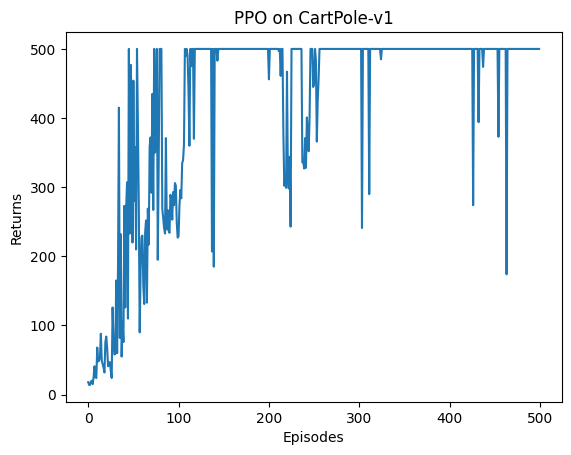

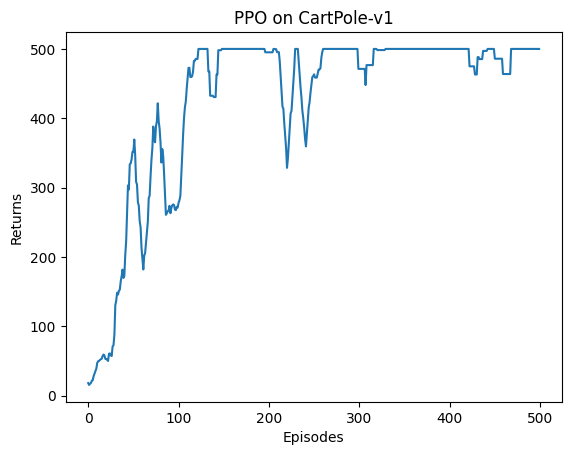

In [8]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

In [9]:
## continuous 智能体
class PolicyNetContinuous(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNetContinuous, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc_mu = torch.nn.Linear(hidden_dim, action_dim)  ## 用来求每个动作正态分布的均值
        self.fc_std = torch.nn.Linear(hidden_dim, action_dim) ## 用来求每个动作正态分布的方差

    ## 要求出摆动作的概率分布，默认是正态分布的
    def forward(self, x):
        x = F.relu(self.fc1(x))
        mu = 2.0 * torch.tanh(self.fc_mu(x))       ## predict每个动作的正态分布的均值，取值区间则是 [-2, 2]
        std = F.softplus(self.fc_std(x))           ## predict每个动作的正态分布的方差，使用了函数 softplus
        return mu, std  # 高斯分布的均值和标准差


class PPOContinuous:
    ''' 处理连续动作的PPO算法 '''
    def __init__(self, state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                 lmbda, epochs, eps, gamma, device):
        ## 状态的dimension，Pendulum-v1是 3 dim，也就是摆末端的(x,y)坐标，和角速度
        ## https://gymnasium.farama.org/environments/classic_control/pendulum/
        self.actor = PolicyNetContinuous(state_dim, hidden_dim,
                                         action_dim).to(device)  ##  策略网络
        self.critic = ValueNet(state_dim, hidden_dim).to(device)##  价值网络
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)  ## 策略网络配置优化器
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)  ## 价值网络配置优化器
        self.gamma = gamma   ## 衰减因子的呢
        self.lmbda = lmbda
        self.epochs = epochs
        self.eps = eps
        self.device = device

    def take_action(self, state): # 根据动作概率分布随机采样
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        mu, std = self.actor(state)      ## 拿到该状态下，均值和标准差
        action_dist = torch.distributions.Normal(mu, std)    ##   配置 好采样的概率
        action = action_dist.sample()       ## 对该状态下，所有的动作采样，采样的分布是高斯分布
        return [action.item()]              ## 返回采样的动作值，也就是力矩的大小

    def update(self, transition_dict):
        ## 拿到这条序列内的 奖励、状态和动作，下一个状态、是否完成的
        states = torch.tensor(transition_dict['states'],
                              dtype=torch.float).to(self.device)
        actions = torch.tensor(transition_dict['actions'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        rewards = torch.tensor(transition_dict['rewards'],
                               dtype=torch.float).view(-1, 1).to(self.device)
        next_states = torch.tensor(transition_dict['next_states'],
                                   dtype=torch.float).to(self.device)
        dones = torch.tensor(transition_dict['dones'],
                             dtype=torch.float).view(-1, 1).to(self.device)
        rewards = (rewards + 8.0) / 8.0  # 和TRPO一样,对奖励进行修改,方便训练
        ## 用下个状态求下一个状态的状态动作价值，然后间接求出当前状态的状态动作价值
        td_target = rewards + self.gamma * self.critic(next_states) * (1 -
                                                                       dones)
        ## 间接求出的价值 - 直接求出的当前状态的状态动作价值，也就是 TD-error，或者是优势函数 A
        td_delta = td_target - self.critic(states)
        ##  算出优势函数值   广义优势估计，也就是平均值的
        advantage = rl_utils.compute_advantage(self.gamma, self.lmbda,
                                               td_delta.cpu()).to(self.device)
        mu, std = self.actor(states)   ## 拿到 continuous 动作分布的均值和方差
        ## 所有动作概率的分布，不反向传播求梯度，detach，给定正态分布的均值和方差，产生正态分布的
        action_dists = torch.distributions.Normal(mu.detach(), std.detach())
        # 动作是正态分布
        old_log_probs = action_dists.log_prob(actions) ## 从产生的正态分布，给出每个动作的概率 log 值

        for _ in range(self.epochs):
            ## 拿到 continuous 动作分布的均值和方差
            mu, std = self.actor(states)
            ## 所有动作概率的分布，不反向传播求梯度，detach，给定正态分布的均值和方差，产生正态分布的
            action_dists = torch.distributions.Normal(mu, std)
            log_probs = action_dists.log_prob(actions)  ## 从产生的正态分布，给出每个动作的概率 log 值
            ## 算重要性采样
            ratio = torch.exp(log_probs - old_log_probs)
            surr1 = ratio * advantage   ## 重要性采样和优势估计相乘的
            surr2 = torch.clamp(ratio, 1 - self.eps, 1 + self.eps) * advantage  # 截断
            ## 算出来的重要性采样，求出两者间的最小值，然后加负号，也就是最大化目标函数，不加负号的话是最小化目标函数
            actor_loss = torch.mean(-torch.min(surr1, surr2))  # PPO损失函数
            ## 直接求出当前状态的状态动作价值，和 间接求出的价值，使用 MSE 来算损失函数的，td_target不反向传播求梯度，detach
            critic_loss = torch.mean(
                F.mse_loss(self.critic(states), td_target.detach()))
            self.actor_optimizer.zero_grad()
            self.critic_optimizer.zero_grad()   ## 价值网络的参数梯度置零的
            actor_loss.backward()
            critic_loss.backward()  ## 价值网络的损失loss反向传播梯度
            self.actor_optimizer.step()
            self.critic_optimizer.step()  # 更新价值函数

In [10]:
actor_lr = 1e-4
critic_lr = 5e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.9
lmbda = 0.9
epochs = 10
eps = 0.2
device = torch.device("cuda") if torch.cuda.is_available() else torch.device(
    "cpu")

env_name = 'Pendulum-v1'
env = gym.make(env_name, render_mode="rgb_array")
_ = env.reset(seed=0)
torch.manual_seed(0)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]  # 连续动作空间
agent = PPOContinuous(state_dim, hidden_dim, action_dim, actor_lr, critic_lr,
                      lmbda, epochs, eps, gamma, device)

return_list = rl_utils.train_on_policy_agent(env, agent, num_episodes)

# Iteration 0: 100%|██████████| 200/200 [02:15<00:00,  1.47it/s, episode=200,
# return=-984.137]
# Iteration 1: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=400,
# return=-895.332]
# Iteration 2: 100%|██████████| 200/200 [02:14<00:00,  1.48it/s, episode=600,
# return=-518.916]
# Iteration 3: 100%|██████████| 200/200 [02:19<00:00,  1.44it/s, episode=800,
# return=-602.183]
# Iteration 4: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1000,
# return=-392.104]
# Iteration 5: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1200,
# return=-259.206]
# Iteration 6: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1400,
# return=-221.772]
# Iteration 7: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1600,
# return=-293.515]
# Iteration 8: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=1800,
# return=-371.194]
# Iteration 9: 100%|██████████| 200/200 [02:17<00:00,  1.45it/s, episode=2000,
# return=-248.958]

Iteration 0:  40%|███████████████                       | 79/200 [00:41<01:03,  1.92it/s, episode=70, return=-1214.618]

KeyboardInterrupt



In [ ]:
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 21)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('PPO on {}'.format(env_name))
plt.show()